Используя PyTorch:

- Создать и обучить регрессионную модель, которая аппроксимирует значение функции sin(x + 2*y)exp(-(2x + y)^2) на диапазоне значений [-10;10] по х и у.
- В качестве обучающей выборки необходимо сгенерировать 20000 точек случайным образом.
- Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно.

Результаты:

- Посчитать метрику Mean Square Error(MSE) на test.
- Нарисовать график, в котором сравнивается истинная функция и ее аппроксимированный вариант (предсказываемый моделью).

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [2]:

# Параметры
N = 20000
X_MIN, X_MAX = -10, 10

X = torch.rand(N, 2) * (X_MAX - X_MIN) + X_MIN

x, y = X[:, 0], X[:, 1]
z = torch.sin(x + 2*y) * torch.exp(-(2*x + y)**2)

indices = torch.randperm(N)
train_size = int(0.7 * N)  # 14000
val_size = int(0.15 * N)   # 3000

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]


X_train, y_train = X[train_idx], z[train_idx]
X_val, y_val = X[val_idx], z[val_idx]
X_test, y_test = X[test_idx], z[test_idx]



Text(0.5, 0.92, 'Обучающие точки (20k)')

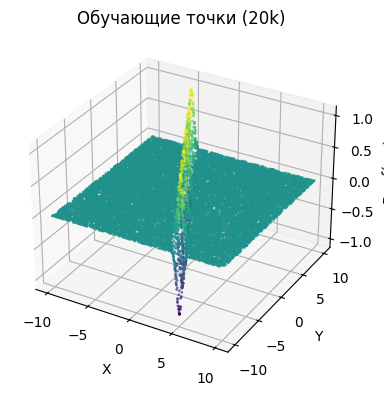

In [13]:
# 1. 3D Scatter Plot обучающих данных
fig = plt.figure(figsize=(15, 5))

# График A: 3D scatter всех точек
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(x, y, z, c =z, s=1, alpha=0.6)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('z = f(x,y)')
ax1.set_title('Обучающие точки (20k)')



In [ ]:
class Net(nn.Module):
    def __init__(self, hidden_size=30, num_hidden_layers=3):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, hidden_size) 
        self.final = nn.Linear(hidden_size, 1)  
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.final(out)
        return out

In [36]:
# Параметры
batch_size = 64
learning_rate = 0.001

In [ ]:

train_dataset = TensorDataset(X_train, y_train.unsqueeze(1)) 
val_dataset   = TensorDataset(X_val,   y_val.unsqueeze(1))
test_dataset  = TensorDataset(X_test,  y_test.unsqueeze(1))



train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)



In [44]:
def train_model(model, criterion, optimizer, num_epochs=10):
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_X, batch_y in train_loader:
            # Прямой проход
            preds = model(batch_X)

            # Потери
            loss = criterion(preds, batch_y)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Обратное распространение
            loss.backward()

            # Шаг оптимизатора
            optimizer.step()

            running_loss += loss.item() * batch_X.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # Простая валидация по MSE
        model.eval()
        val_loss = 0.0
        with torch.no_grad():                     # без градиентов на валидации [web:28][web:31]
            for batch_X, batch_y in val_loader:
                preds = model(batch_X)
                loss = criterion(preds, batch_y)
                val_loss += loss.item() * batch_X.size(0)

        val_loss /= len(val_loader.dataset)
        train_history.append(train_loss)
        val_history.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} | train MSE: {train_loss:.6f} | val MSE: {val_loss:.6f}")
        
    return train_history, val_history


In [52]:
model = Net(hidden_size=100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

Epoch 1/200 | train MSE: 0.025584 | val MSE: 0.019107
Epoch 2/200 | train MSE: 0.016394 | val MSE: 0.018267
Epoch 3/200 | train MSE: 0.015980 | val MSE: 0.018162
Epoch 4/200 | train MSE: 0.015879 | val MSE: 0.018030
Epoch 5/200 | train MSE: 0.015823 | val MSE: 0.018073
Epoch 6/200 | train MSE: 0.015785 | val MSE: 0.018079
Epoch 7/200 | train MSE: 0.015733 | val MSE: 0.017941
Epoch 8/200 | train MSE: 0.015685 | val MSE: 0.018042
Epoch 9/200 | train MSE: 0.015618 | val MSE: 0.017857
Epoch 10/200 | train MSE: 0.015582 | val MSE: 0.017784
Epoch 11/200 | train MSE: 0.015521 | val MSE: 0.017718
Epoch 12/200 | train MSE: 0.015455 | val MSE: 0.017737
Epoch 13/200 | train MSE: 0.015367 | val MSE: 0.017627
Epoch 14/200 | train MSE: 0.015269 | val MSE: 0.017640
Epoch 15/200 | train MSE: 0.015187 | val MSE: 0.017557
Epoch 16/200 | train MSE: 0.015114 | val MSE: 0.017490
Epoch 17/200 | train MSE: 0.014892 | val MSE: 0.017297
Epoch 18/200 | train MSE: 0.014694 | val MSE: 0.017022
Epoch 19/200 | trai

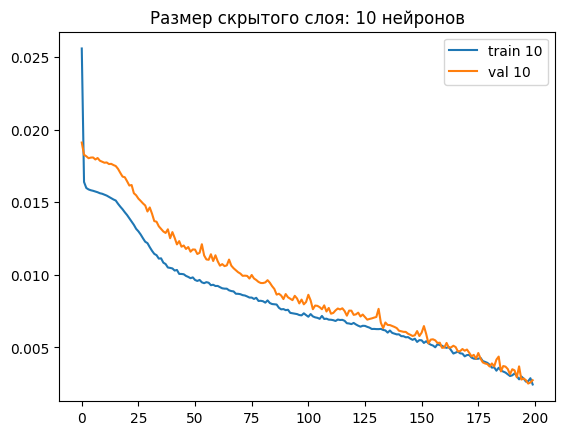

Epoch 1/200 | train MSE: 0.016284 | val MSE: 0.018101
Epoch 2/200 | train MSE: 0.015670 | val MSE: 0.017755
Epoch 3/200 | train MSE: 0.015404 | val MSE: 0.017450
Epoch 4/200 | train MSE: 0.015292 | val MSE: 0.017645
Epoch 5/200 | train MSE: 0.015065 | val MSE: 0.017028
Epoch 6/200 | train MSE: 0.014727 | val MSE: 0.017286
Epoch 7/200 | train MSE: 0.014398 | val MSE: 0.016363
Epoch 8/200 | train MSE: 0.013995 | val MSE: 0.016478
Epoch 9/200 | train MSE: 0.013594 | val MSE: 0.015768
Epoch 10/200 | train MSE: 0.013178 | val MSE: 0.015209
Epoch 11/200 | train MSE: 0.012823 | val MSE: 0.016208
Epoch 12/200 | train MSE: 0.012578 | val MSE: 0.015489
Epoch 13/200 | train MSE: 0.012124 | val MSE: 0.014432
Epoch 14/200 | train MSE: 0.011779 | val MSE: 0.014268
Epoch 15/200 | train MSE: 0.011483 | val MSE: 0.013904
Epoch 16/200 | train MSE: 0.011283 | val MSE: 0.013681
Epoch 17/200 | train MSE: 0.011076 | val MSE: 0.014786
Epoch 18/200 | train MSE: 0.011000 | val MSE: 0.013082
Epoch 19/200 | trai

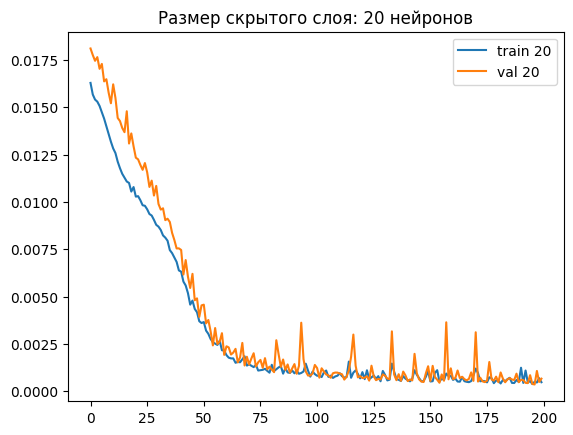

Epoch 1/200 | train MSE: 0.016554 | val MSE: 0.017617
Epoch 2/200 | train MSE: 0.015191 | val MSE: 0.017606
Epoch 3/200 | train MSE: 0.014318 | val MSE: 0.016119
Epoch 4/200 | train MSE: 0.013284 | val MSE: 0.015510
Epoch 5/200 | train MSE: 0.012597 | val MSE: 0.014671
Epoch 6/200 | train MSE: 0.011972 | val MSE: 0.014542
Epoch 7/200 | train MSE: 0.011653 | val MSE: 0.014003
Epoch 8/200 | train MSE: 0.011393 | val MSE: 0.013333
Epoch 9/200 | train MSE: 0.010923 | val MSE: 0.013073
Epoch 10/200 | train MSE: 0.010765 | val MSE: 0.012478
Epoch 11/200 | train MSE: 0.010529 | val MSE: 0.012949
Epoch 12/200 | train MSE: 0.010114 | val MSE: 0.011967
Epoch 13/200 | train MSE: 0.009852 | val MSE: 0.011872
Epoch 14/200 | train MSE: 0.009566 | val MSE: 0.010956
Epoch 15/200 | train MSE: 0.009524 | val MSE: 0.010840
Epoch 16/200 | train MSE: 0.009048 | val MSE: 0.010539
Epoch 17/200 | train MSE: 0.008970 | val MSE: 0.010215
Epoch 18/200 | train MSE: 0.008731 | val MSE: 0.009896
Epoch 19/200 | trai

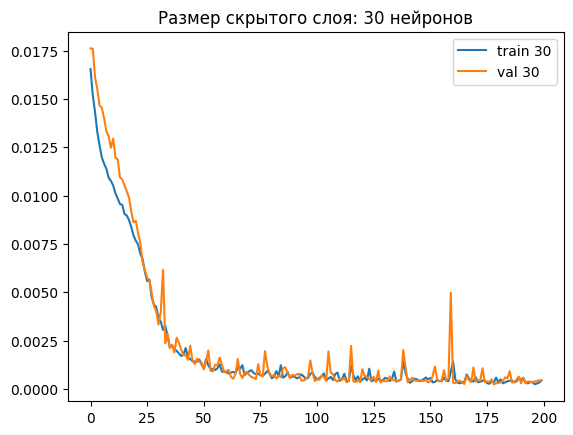

Epoch 1/200 | train MSE: 0.018696 | val MSE: 0.017811
Epoch 2/200 | train MSE: 0.015602 | val MSE: 0.017759
Epoch 3/200 | train MSE: 0.015254 | val MSE: 0.017133
Epoch 4/200 | train MSE: 0.014327 | val MSE: 0.016083
Epoch 5/200 | train MSE: 0.013467 | val MSE: 0.015249
Epoch 6/200 | train MSE: 0.012708 | val MSE: 0.014406
Epoch 7/200 | train MSE: 0.011965 | val MSE: 0.014160
Epoch 8/200 | train MSE: 0.011560 | val MSE: 0.013196
Epoch 9/200 | train MSE: 0.011107 | val MSE: 0.012737
Epoch 10/200 | train MSE: 0.010785 | val MSE: 0.013388
Epoch 11/200 | train MSE: 0.010714 | val MSE: 0.012237
Epoch 12/200 | train MSE: 0.010440 | val MSE: 0.012314
Epoch 13/200 | train MSE: 0.010157 | val MSE: 0.011564
Epoch 14/200 | train MSE: 0.010116 | val MSE: 0.011437
Epoch 15/200 | train MSE: 0.009995 | val MSE: 0.011108
Epoch 16/200 | train MSE: 0.009708 | val MSE: 0.010743
Epoch 17/200 | train MSE: 0.009709 | val MSE: 0.010749
Epoch 18/200 | train MSE: 0.009314 | val MSE: 0.010371
Epoch 19/200 | trai

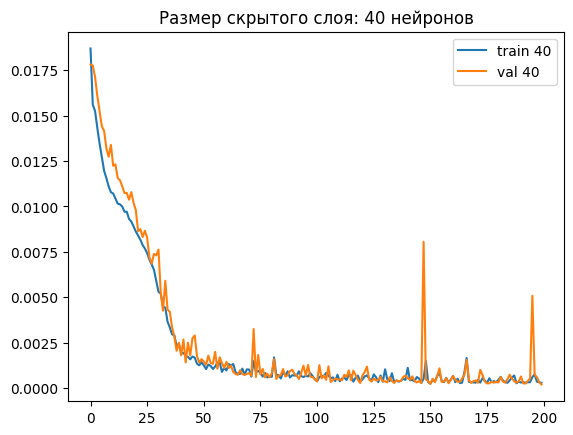

Epoch 1/200 | train MSE: 0.017196 | val MSE: 0.018340
Epoch 2/200 | train MSE: 0.015440 | val MSE: 0.017582
Epoch 3/200 | train MSE: 0.014556 | val MSE: 0.016228
Epoch 4/200 | train MSE: 0.013309 | val MSE: 0.015543
Epoch 5/200 | train MSE: 0.012291 | val MSE: 0.014646
Epoch 6/200 | train MSE: 0.011604 | val MSE: 0.013652
Epoch 7/200 | train MSE: 0.011316 | val MSE: 0.012828
Epoch 8/200 | train MSE: 0.010418 | val MSE: 0.011300
Epoch 9/200 | train MSE: 0.009698 | val MSE: 0.010845
Epoch 10/200 | train MSE: 0.009549 | val MSE: 0.010394
Epoch 11/200 | train MSE: 0.009004 | val MSE: 0.010257
Epoch 12/200 | train MSE: 0.009024 | val MSE: 0.009943
Epoch 13/200 | train MSE: 0.008608 | val MSE: 0.009268
Epoch 14/200 | train MSE: 0.008182 | val MSE: 0.009113
Epoch 15/200 | train MSE: 0.007806 | val MSE: 0.008973
Epoch 16/200 | train MSE: 0.007315 | val MSE: 0.008498
Epoch 17/200 | train MSE: 0.006595 | val MSE: 0.007261
Epoch 18/200 | train MSE: 0.006316 | val MSE: 0.005389
Epoch 19/200 | trai

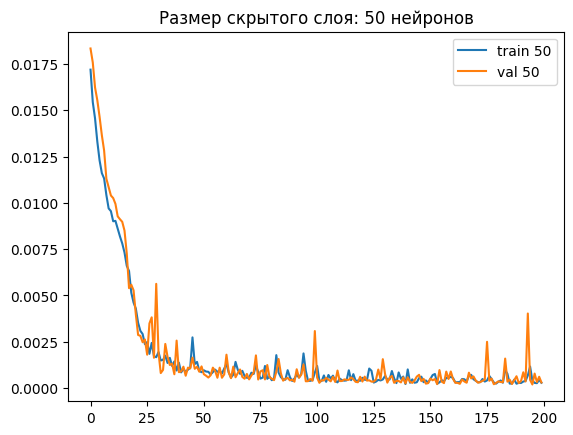

Epoch 1/200 | train MSE: 0.016767 | val MSE: 0.018140
Epoch 2/200 | train MSE: 0.015169 | val MSE: 0.017156
Epoch 3/200 | train MSE: 0.013886 | val MSE: 0.015759
Epoch 4/200 | train MSE: 0.012584 | val MSE: 0.015172
Epoch 5/200 | train MSE: 0.011881 | val MSE: 0.013920
Epoch 6/200 | train MSE: 0.011279 | val MSE: 0.013245
Epoch 7/200 | train MSE: 0.011135 | val MSE: 0.013042
Epoch 8/200 | train MSE: 0.010537 | val MSE: 0.012070
Epoch 9/200 | train MSE: 0.009981 | val MSE: 0.011201
Epoch 10/200 | train MSE: 0.009844 | val MSE: 0.010565
Epoch 11/200 | train MSE: 0.009548 | val MSE: 0.011345
Epoch 12/200 | train MSE: 0.009271 | val MSE: 0.010187
Epoch 13/200 | train MSE: 0.009223 | val MSE: 0.010501
Epoch 14/200 | train MSE: 0.008987 | val MSE: 0.009812
Epoch 15/200 | train MSE: 0.008996 | val MSE: 0.010170
Epoch 16/200 | train MSE: 0.008785 | val MSE: 0.010737
Epoch 17/200 | train MSE: 0.008445 | val MSE: 0.008740
Epoch 18/200 | train MSE: 0.008338 | val MSE: 0.008852
Epoch 19/200 | trai

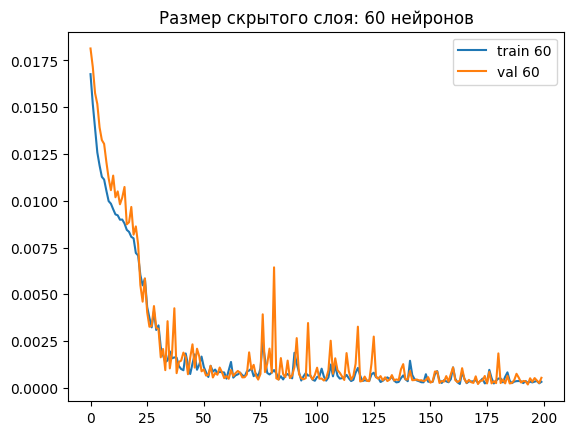

Epoch 1/200 | train MSE: 0.018429 | val MSE: 0.017531
Epoch 2/200 | train MSE: 0.014847 | val MSE: 0.016469
Epoch 3/200 | train MSE: 0.013530 | val MSE: 0.015344
Epoch 4/200 | train MSE: 0.012308 | val MSE: 0.014560
Epoch 5/200 | train MSE: 0.011778 | val MSE: 0.013911
Epoch 6/200 | train MSE: 0.011488 | val MSE: 0.014069
Epoch 7/200 | train MSE: 0.011126 | val MSE: 0.013224
Epoch 8/200 | train MSE: 0.010809 | val MSE: 0.012649
Epoch 9/200 | train MSE: 0.010678 | val MSE: 0.012262
Epoch 10/200 | train MSE: 0.010216 | val MSE: 0.011791
Epoch 11/200 | train MSE: 0.009990 | val MSE: 0.010975
Epoch 12/200 | train MSE: 0.009524 | val MSE: 0.010665
Epoch 13/200 | train MSE: 0.009304 | val MSE: 0.010009
Epoch 14/200 | train MSE: 0.009138 | val MSE: 0.009713
Epoch 15/200 | train MSE: 0.008975 | val MSE: 0.009382
Epoch 16/200 | train MSE: 0.008668 | val MSE: 0.009449
Epoch 17/200 | train MSE: 0.008405 | val MSE: 0.008560
Epoch 18/200 | train MSE: 0.008072 | val MSE: 0.008517
Epoch 19/200 | trai

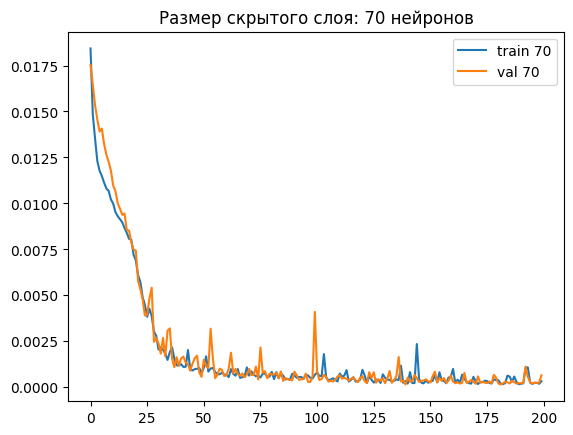

Epoch 1/200 | train MSE: 0.017166 | val MSE: 0.017547
Epoch 2/200 | train MSE: 0.015149 | val MSE: 0.016693
Epoch 3/200 | train MSE: 0.013318 | val MSE: 0.015331
Epoch 4/200 | train MSE: 0.012353 | val MSE: 0.014683
Epoch 5/200 | train MSE: 0.011720 | val MSE: 0.014059
Epoch 6/200 | train MSE: 0.011410 | val MSE: 0.013887
Epoch 7/200 | train MSE: 0.010976 | val MSE: 0.012808
Epoch 8/200 | train MSE: 0.010435 | val MSE: 0.011876
Epoch 9/200 | train MSE: 0.010144 | val MSE: 0.011374
Epoch 10/200 | train MSE: 0.009593 | val MSE: 0.010898
Epoch 11/200 | train MSE: 0.009563 | val MSE: 0.010688
Epoch 12/200 | train MSE: 0.009312 | val MSE: 0.010265
Epoch 13/200 | train MSE: 0.009138 | val MSE: 0.012063
Epoch 14/200 | train MSE: 0.009195 | val MSE: 0.009853
Epoch 15/200 | train MSE: 0.008551 | val MSE: 0.009265
Epoch 16/200 | train MSE: 0.008230 | val MSE: 0.009119
Epoch 17/200 | train MSE: 0.007905 | val MSE: 0.008226
Epoch 18/200 | train MSE: 0.007861 | val MSE: 0.008957
Epoch 19/200 | trai

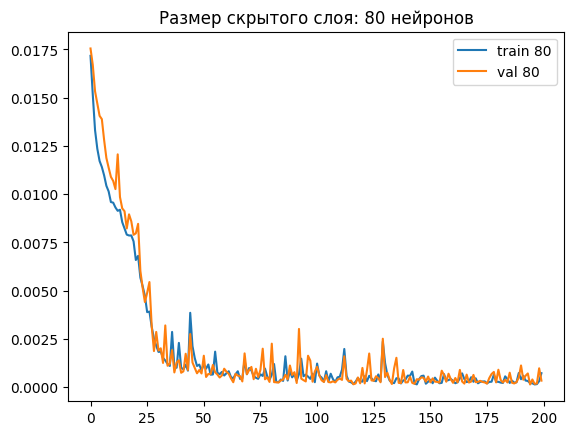

Epoch 1/200 | train MSE: 0.016642 | val MSE: 0.017305
Epoch 2/200 | train MSE: 0.014086 | val MSE: 0.016332
Epoch 3/200 | train MSE: 0.012784 | val MSE: 0.014738
Epoch 4/200 | train MSE: 0.011914 | val MSE: 0.014285
Epoch 5/200 | train MSE: 0.011162 | val MSE: 0.013170
Epoch 6/200 | train MSE: 0.010703 | val MSE: 0.011662
Epoch 7/200 | train MSE: 0.010028 | val MSE: 0.010771
Epoch 8/200 | train MSE: 0.009489 | val MSE: 0.010225
Epoch 9/200 | train MSE: 0.009542 | val MSE: 0.010335
Epoch 10/200 | train MSE: 0.009147 | val MSE: 0.010120
Epoch 11/200 | train MSE: 0.009061 | val MSE: 0.009538
Epoch 12/200 | train MSE: 0.008778 | val MSE: 0.009645
Epoch 13/200 | train MSE: 0.008666 | val MSE: 0.009722
Epoch 14/200 | train MSE: 0.008331 | val MSE: 0.008904
Epoch 15/200 | train MSE: 0.007868 | val MSE: 0.008324
Epoch 16/200 | train MSE: 0.008173 | val MSE: 0.007913
Epoch 17/200 | train MSE: 0.007562 | val MSE: 0.008157
Epoch 18/200 | train MSE: 0.007323 | val MSE: 0.008225
Epoch 19/200 | trai

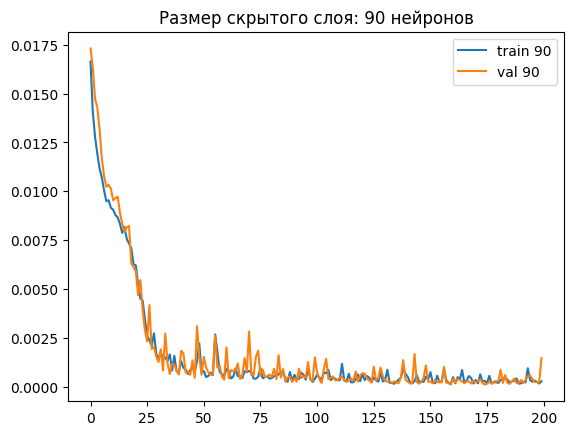

In [56]:
for hidden_size in range(10, 100, 10):
    model = Net(hidden_size=hidden_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
    train_history, val_history = train_model(model, criterion, optimizer, num_epochs=200)
    plt.title(f'Размер скрытого слоя: {hidden_size} нейронов')
    plt.plot(train_history, label=f'train {hidden_size}')
    plt.plot(val_history, label=f'val {hidden_size}')
    plt.legend()   
    plt.show()

Epoch 100/100 | train MSE: 0.000497 | val MSE: 0.000331

Наиболее перспективно выглядит модели на 30-40 нейронов

In [57]:
model = Net(hidden_size=30)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

Epoch 1/200 | train MSE: 0.016253 | val MSE: 0.017890
Epoch 2/200 | train MSE: 0.015742 | val MSE: 0.017783
Epoch 3/200 | train MSE: 0.015430 | val MSE: 0.017621
Epoch 4/200 | train MSE: 0.015219 | val MSE: 0.017390
Epoch 5/200 | train MSE: 0.014830 | val MSE: 0.016893
Epoch 6/200 | train MSE: 0.014262 | val MSE: 0.016025
Epoch 7/200 | train MSE: 0.013661 | val MSE: 0.015517
Epoch 8/200 | train MSE: 0.012863 | val MSE: 0.014935
Epoch 9/200 | train MSE: 0.012319 | val MSE: 0.014471
Epoch 10/200 | train MSE: 0.011788 | val MSE: 0.013957
Epoch 11/200 | train MSE: 0.011323 | val MSE: 0.013508
Epoch 12/200 | train MSE: 0.010840 | val MSE: 0.013111
Epoch 13/200 | train MSE: 0.010413 | val MSE: 0.012567
Epoch 14/200 | train MSE: 0.010068 | val MSE: 0.012318
Epoch 15/200 | train MSE: 0.009884 | val MSE: 0.012016
Epoch 16/200 | train MSE: 0.009640 | val MSE: 0.011503
Epoch 17/200 | train MSE: 0.009409 | val MSE: 0.011529
Epoch 18/200 | train MSE: 0.009277 | val MSE: 0.011486
Epoch 19/200 | trai

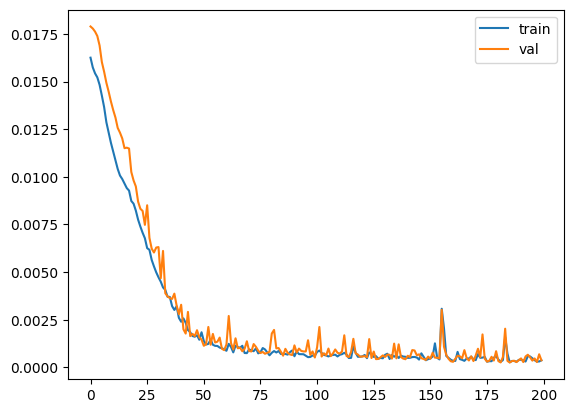

In [58]:
train_history, val_history = train_model(model, criterion, optimizer, num_epochs=200)

plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.legend()   
plt.show()

In [59]:
model_200 = model

Epoch 1/100 | train MSE: 0.000258 | val MSE: 0.000282
Epoch 2/100 | train MSE: 0.000198 | val MSE: 0.000225
Epoch 3/100 | train MSE: 0.000183 | val MSE: 0.000320
Epoch 4/100 | train MSE: 0.000246 | val MSE: 0.000143
Epoch 5/100 | train MSE: 0.000156 | val MSE: 0.000271
Epoch 6/100 | train MSE: 0.000207 | val MSE: 0.000176
Epoch 7/100 | train MSE: 0.000430 | val MSE: 0.000427
Epoch 8/100 | train MSE: 0.000281 | val MSE: 0.000280
Epoch 9/100 | train MSE: 0.000601 | val MSE: 0.000382
Epoch 10/100 | train MSE: 0.000252 | val MSE: 0.000157
Epoch 11/100 | train MSE: 0.000134 | val MSE: 0.000259
Epoch 12/100 | train MSE: 0.000224 | val MSE: 0.000172
Epoch 13/100 | train MSE: 0.000173 | val MSE: 0.000429
Epoch 14/100 | train MSE: 0.000175 | val MSE: 0.000168
Epoch 15/100 | train MSE: 0.000379 | val MSE: 0.000192
Epoch 16/100 | train MSE: 0.000365 | val MSE: 0.000327
Epoch 17/100 | train MSE: 0.000201 | val MSE: 0.000261
Epoch 18/100 | train MSE: 0.000191 | val MSE: 0.000144
Epoch 19/100 | trai

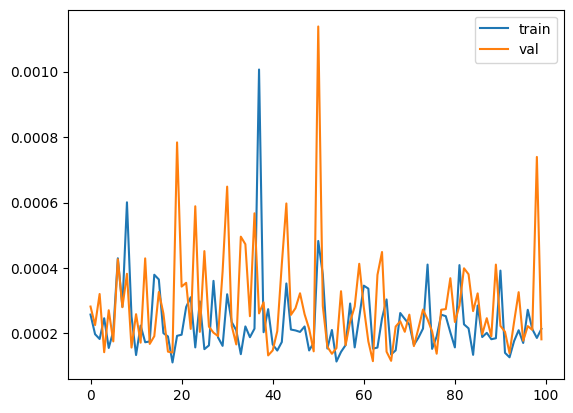

In [62]:
# Попробуем еще 100 эпох
train_history, val_history = train_model(model, criterion, optimizer, num_epochs=100)

plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.legend()   
plt.show()

In [63]:
mse_test = criterion(model(X_test), y_test.unsqueeze(1))
print(f"MSE на тестовых данных: {mse_test.item():.6f}, RMSE: {mse_test.sqrt().item():.6f}")

MSE на тестовых данных: 0.000166, RMSE: 0.012879


В принципе результат выглядит неплохим.
Строим график


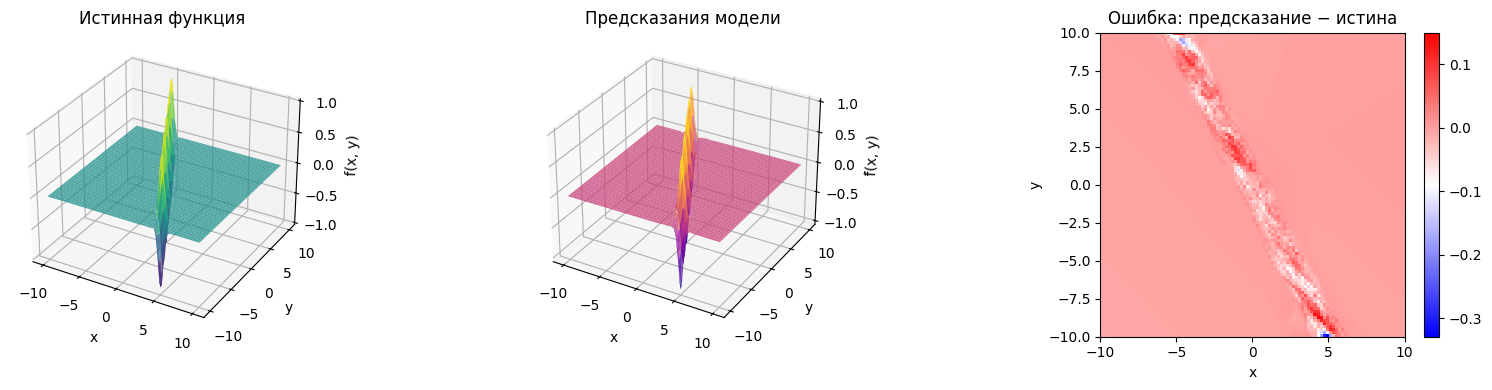

In [65]:
model.eval()


n_points = 100
xs = np.linspace(-10, 10, n_points)
ys = np.linspace(-10, 10, n_points)
Xg, Yg = np.meshgrid(xs, ys)  


Z_true = np.sin(Xg + 2 * Yg) * np.exp(-(2 * Xg + Yg) ** 2)


XY_grid = np.stack([Xg.ravel(), Yg.ravel()], axis=1)          
XY_grid_tensor = torch.tensor(XY_grid, dtype=torch.float32)   


with torch.no_grad():
    Z_pred = model(XY_grid_tensor).numpy().reshape(Xg.shape)  # (n_points, n_points)


fig = plt.figure(figsize=(16, 4))

# Истинная функция (3D surface) ---
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(Xg, Yg, Z_true, cmap='viridis', alpha=0.8)
ax1.set_title('Истинная функция')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('f(x, y)')

# Предсказание модели (3D surface) ---
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(Xg, Yg, Z_pred, cmap='plasma', alpha=0.8)
ax2.set_title('Предсказания модели')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('f̂(x, y)')

#  Карта ошибки (heatmap) ---
ax3 = fig.add_subplot(133)
err = Z_pred - Z_true
im = ax3.imshow(
    err,
    extent=[xs.min(), xs.max(), ys.min(), ys.max()],
    origin='lower',
    cmap='bwr'
)
ax3.set_title('Ошибка: предсказание − истина')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
